In [1]:
import xarray as xr, matplotlib, matplotlib.pyplot as plt, glob, re, os, pandas as pd, geopandas as gpd, regionmask, numpy as np
from dateutil.relativedelta import relativedelta
from shapely.geometry import Polygon
matplotlib.rcParams['savefig.bbox'] = "tight"    # always save with tight bounding box

from IPython.display import clear_output

Xn,Xx,Yn,Yx = [-80,-50,-60,-30]

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires/"

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/miniforge3/envs/wwa/share/proj failed


In [2]:
def wrap_lon(ds):
    
    # method to 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds


def awmean(da): return da.weighted(np.cos(np.deg2rad(da.lat))).mean(["lat", "lon"])


def decode_times(ts):
    
    # Method to manually decode times
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts
    

def main_polygon(gdf):
    gdf = gdf.dissolve().explode(index_parts = False)
    gdf = gdf.loc[gdf.geometry.area == gdf.geometry.area.max()]
    return gdf

In [3]:
gcm_short = {'CCCma-CanESM2' : 'CanESM2',
             'CNRM-CERFACS-CNRM-CM5':'CNRM-CM5',
             'CSIRO-QCCCE-CSIRO-Mk3-6-0':'CSIRO-Mk3-6-0',
             'ICHEC-EC-EARTH':'EC-EARTH',
             'IPSL-IPSL-CM5A-LR':'IPSL-CM5A-LR',
             'IPSL-IPSL-CM5A-MR':'IPSL-CM5A-MR',
             'MIROC-MIROC5':'MIROC5',
             'MOHC-HadGEM2-ES':'HadGEM2-ES',
             'MPI-M-MPI-ESM-LR':'MPI-ESM-LR',
             'MPI-M-MPI-ESM-MR':'MPI-ESM-MR',
             'NCC-NorESM1-M':'NorESM1-M',
             'NOAA-GFDL-GFDL-ESM2M':'GFDL-ESM2M'}

rcm_short = {'CCCma-CanRCM4':'CanRCM4',
             'CLMcom-CCLM4-8-17':'CCLM4-8-17',
             'CLMcom-KIT-CCLM5-0-15':'CCLM5-0-15',
             'CLMcom-ETH-COSMO-crCLIM-v1-1':'COSMO-crCLIM-v1-1',
             'CNRM-ALADIN53':'ALADIN53',
             'CNRM-ALADIN63':'ALADIN63',
             'DMI-HIRHAM5':'HIRHAM5',
             'GERICS-REMO2009':'REMO2009',
             'GERICS-REMO2015':'REMO2015',
             'ICTP-RegCM4-3':'RegCM4-3',
             'ICTP-RegCM4-6':'RegCM4-6',
             'ICTP-RegCM4-7':'RegCM4-7',
             'IPSL-WRF381P':'WRF381P',
             'KNMI-RACMO22E':'RACMO22E',
             'KNMI-RACMO22T':'RACMO22T',
             'MOHC-HadREM3-GA7-05':'HadREM3-GA7-05',
             'MPI-CSC-REMO2009':'REMO2009',
             'OURANOS-CRCM5' : 'CRCM5',
             'SMHI-RCA4':'RCA4',
             'UCAN-WRF341I':'WRF341I',
             'UHOH-WRF361H':'WRF361H',
             'RMIB-UGent-ALARO-0':"ALARO-0"}

# MODIS 

In [ ]:
! cd data;wget https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_M-C61_712178.zip; unzip DL_FIRE_M-C61_712178.zip; rm DL_FIRE_M-C61_712178.zip

In [ ]:
# load all active fire data
df = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("data/*M-C61*.csv")])

# filter out low-confidence points
df = df.loc[(df.confidence >= 80), ["latitude", "longitude"]]
df.to_csv("data/modis_conf-80.csv")

In [ ]:
df.loc["2026-01"]

# Shapefiles 

In [ ]:
# original Chile study was a box
xn,xx,yn,yx = [-72, -70.8, -33.9, -32]
sf = gpd.GeoDataFrame(index=["chile2024"], crs='epsg:4326', geometry=[Polygon(zip([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn]))])
sf = main_polygon(sf.clip(regionmask.defined_regions.natural_earth_v5_1_2.land_10.to_geodataframe().set_crs("epsg:4326")))
sf.to_file("sf_chile2024/sf_chile2024.shp", mode = "w")

In [ ]:
# start with a box for Chile
# xn,xx,yn,yx = [-74, -72, -39, -36] # original definition
xn,xx,yn,yx = [-74, -71.5, -38, -36] # revised definition
sf = gpd.GeoDataFrame(index=["chile2026"], crs='epsg:4326', geometry=[Polygon(zip([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn]))])
sf = main_polygon(sf.clip(regionmask.defined_regions.natural_earth_v5_1_2.land_10.to_geodataframe().set_crs("epsg:4326")))
sf.to_file("sf_chile2026/sf_chile2026.shp", mode = "w")

In [ ]:
# start with a box for Patagonia
xn,xx,yn,yx = [-72.6, -70.6, -43.4, -41.4]
sf = gpd.GeoDataFrame(index=["patagonia"], crs='epsg:4326', geometry=[Polygon(zip([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn]))])
# only a tiny portion of sea surface so won't clip at this point
sf.to_file("sf_patagonia/sf_patagonia.shp", mode = "w")

# Compile latest data from CDS

## Precip

In [4]:
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-07/a8341c36a988bdf5274815d73bcae225.nc -O $fpath/obs/pr-monthly_era5land_sam_1950-2026.nc

--2026-02-07 13:37:22--  https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-07/a8341c36a988bdf5274815d73bcae225.nc
Resolving object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)... 2a0c:5bc0:4c:ff::889c:8803, 136.156.136.3
Connecting to object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)|2a0c:5bc0:4c:ff::889c:8803|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12396136 (12M) [application/netcdf]
Saving to: ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires//obs/pr-monthly_era5land_sam_1950-2026.nc’

/rds/general/user/c 100%[===================>]  11.82M  38.5MB/s    in 0.3s    

2026-02-07 13:37:22 (38.5 MB/s) - ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires//obs/pr-monthly_era5land_sam_1950-2026.nc’ saved [12396136/12396136]



In [ ]:
# fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires"

# # get monthly data from CDS
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-2/2026-02-04/861967a99d56f9efd19d441d924e5f79.nc -O $fpath/era5land/pr-monthly_era5land_sam_1950-2025.nc

# # get daily data from CDS where monthly is not yet available
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-04/15563a2416a3222dc3e78fdc3eaf7117.nc -O $fpath/era5land/pr_era5land_sam_2026-01.nc

# # November data to check compatibility of units
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-2/2026-02-04/3b956a612423eee8a884b8bbfdfa0483.nc -O $fpath/era5land/pr_era5land_sam_2025-11.nc

# clear_output(wait = False)

# pr_2026 = xr.open_dataset(fpath+"/era5land/pr_era5land_sam_2026-01.nc").tp.reset_coords(drop = True)
# pr_hist_monthly = xr.open_dataset(fpath+"/era5land/pr-monthly_era5land_sam_1950-2025.nc").tp.reset_coords(drop = True)

# pr_2026_monthly = pr_2026.resample(valid_time = "MS").mean()    # use daily mean rate for compatibility with monthly average from CDS

# # concat & save
# pr = xr.concat([pr_hist_monthly, pr_2026_monthly], "valid_time").rename(valid_time = "time")
# pr.to_netcdf(fpath+"/obs/pr-monthly_era5land_sam_1950-2026.nc")

# # check units
# pr_202511 = xr.open_dataset(fpath+"/era5land/pr_era5land_sam_2025-11.nc").tp.reset_coords(drop = True).mean("valid_time")

# # values don't match but same order of magnitude, so assume units are same
# print("daily mean:", pr_202511.mean(["latitude", "longitude"]).round(5).values)
# print("monthly mean:", pr_hist_monthly.sel(valid_time = "2025-11").mean().round(5).values)

## PEV

In [10]:
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-07/2633b1a446ba04436e4868d7090e374c.nc -O $fpath/obs/pev-monthly_era5land_sam_1950-2026.nc

--2026-02-07 14:03:44--  https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-07/2633b1a446ba04436e4868d7090e374c.nc
Resolving object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)... 2a0c:5bc0:4c:ff::889c:8803, 136.156.136.3
connected. to object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)|2a0c:5bc0:4c:ff::889c:8803|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 13056267 (12M) [application/netcdf]
Saving to: ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires//obs/pev-monthly_era5land_sam_1950-2026.nc’

/rds/general/user/c 100%[===================>]  12.45M  36.4MB/s    in 0.3s    

utime(/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires//obs/pev-monthly_era5land_sam_1950-2026.nc): Operation not permitted
2026-02-07 14:03:45 (36.4 MB/s) - ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires//obs/pev-monthly_era5land_sam_1950-2026.nc’ saved [13056267/130

## sfcWindmax

In [ ]:
fnm = "data/uv10_era5land_2025-12.grib"
fnm_out = "data/sfcWindmax_2025-12.grib"

In [ ]:
! module load CDO/2.4.4-gompi-2024a; cdo -daymax -expr,wind="sqrt(var165*var165+var166*var166)" $fnm $fnm_out
! module load CDO/2.4.4-gompi-2024a; cdo -selvar,var165 $fnm data/u10.grib

In [ ]:
! module load CDO/2.4.4-gompi-2024a; cdo -f nc -daymax -expr,sfcWindmax="sqrt(var165*var165+var166*var166)" -mergetime data/uv10_era5land_2025-12.grib $fpath/sfcWindmax_era5land_sam_2025-12.nc
! module load CDO/2.4.4-gompi-2024a; cdo -f nc -daymax -expr,sfcWindmax="sqrt(var165*var165+var166*var166)" -mergetime data/uv10_era5land_2026-01.grib $fpath/sfcWindmax_era5land_sam_2026-01.nc

## tasmin & tasmax

In [ ]:
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-3/2026-02-04/6a85bd2312abe8575cdd3f518506b962.grib -O $fpath/era5land/t2m-hourly_2026-01.grib
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-3/2026-02-04/8521897d3c8eabf48e4c28b9face4eae.grib -O $fpath/era5land/t2m-hourly_2025-12.grib
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-04/9c276827b3f7827a282af917b64d78c4.grib -O $fpath/era5land/t2m-hourly_2025-11.grib
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-04/68c0cc12a3c2b84ac8906d0d59f4c471.grib -O $fpath/era5land/t2m-hourly_2025-01.grib

clear_output(wait = False)

In [68]:
! module load CDO/2.4.4-gompi-2024a; cdo -O -f nc -daymin -mergetime $fpath/era5land/t2m-hourly_*.grib $fpath/era5land/pet/tasmin_era5land_sam_2025-2026.nc
! module load CDO/2.4.4-gompi-2024a; cdo -O -f nc -daymax -mergetime $fpath/era5land/t2m-hourly_*.grib $fpath/era5land/pet/tasmax_era5land_sam_2025-2026.nc

cdo(1) mergetime: Process started
cdo    daymin: Processed 306810504 values from 1 variable over 2904 timesteps [1.97s 151MB]
cdo(1) mergetime: Process started
cdo    daymax: Processed 306810504 values from 1 variable over 2904 timesteps [1.94s 152MB]


In [ ]:
tmin_hist = xr.open_dataset(fpath+"/era5land/tasmin_1970-2025.grib").t2m.reset_coords(drop = True).rename("tasmin").sel(time = slice("1978","2024"))
tmin_hist.to_netcdf(fpath+"/era5land/pet/tasmin_1978-2024.nc")

tmax_hist = xr.open_dataset(fpath+"/era5land/tasmax_1970-2025.grib").t2m.reset_coords(drop = True).rename("tasmax").sel(time = slice("1978","2024"))
tmax_hist.to_netcdf(fpath+"/era5land/pet/tasmax_1978-2024.nc")

In [ ]:
tmin = xr.open_dataset(fpath+"/era5land/pet/tasmin_era5land_sam_2025-2026.nc")
tmax = xr.open_dataset(fpath+"/era5land/pet/tasmax_era5land_sam_2025-2026.nc")

## ERA5 FWI

In [ ]:
fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/fire_data/fwi/*.nc"))

In [ ]:
fwi_hist = wrap_lon(xr.open_mfdataset(fl[:-1]).fwi.reset_coords(drop = True)).sel(longitude = slice(Xn,Xx), latitude = slice(Yn,Yx))

In [ ]:
fwi_2025 = wrap_lon(xr.open_dataset(fl[-1]).fwinx.rename("fwi", valid_time = "time").reset_coords(drop = True)).sel(longitude = slice(Xn,Xx), latitude = slice(Yn,Yx))

In [ ]:
fwi_sam = xr.concat([fwi_hist, fwi_2025], "time")

In [ ]:
fwi_sam.to_netcdf(fpath+"fwi-era5_1940-2026.nc")

# Extract time series using shapefiles

In [5]:
sf_chile2024 = gpd.read_file("sf_chile2024")
sf_chile2026 = gpd.read_file("sf_chile2026")
sf_patagonia = gpd.read_file("sf_patagonia")

## ERA5land

In [ ]:
for fnm in glob.glob(fpath+"/obs/pev*_sam_*.nc"):
    da = xr.open_dataset(fnm)
    da = da[list(da.data_vars)[0]].reset_coords(drop = True)

    if "longitude" in da.dims: da = da.rename(longitude = "lon", latitude = "lat")

    for i in range(3):

        sf_nm = ["chile2024", "chile2026", "patagonia"][i]
        new_fnm = "data/"+re.sub("sam", sf_nm, fnm.split("/")[-1])

        if os.path.exists(new_fnm): continue

        sf = eval("sf_"+sf_nm)
        da_masked = da.where(regionmask.mask_geopandas(sf, da) == 0, drop = True)
        ts = da_masked.mean(["lat", "lon"])
        ts.to_netcdf(new_fnm)

print("Done.")

### PET
Get time series from each block & merge (grids are slightly different, depending where the data was obtained)

In [ ]:
pet_hist = xr.open_dataset(fpath+"/era5land/pet/petHg85_era5land_sam_1978-2024.nc").pet.rename(latitude = "lat", longitude = "lon")
pet_2025 = xr.open_dataset(fpath+"/era5land/pet/petHg85_era5land_sam_2025-2026.nc").pet

for i in range(3):

    sf_nm = ["chile2024", "chile2026", "patagonia"][i]
    new_fnm = "data/pet_era5land_"+sf_nm+"_1978-2026.nc"
    if os.path.exists(new_fnm): continue

    sf = eval("sf_"+sf_nm)

    ts_hist = pet_hist.where(regionmask.mask_geopandas(sf, pet_hist) == 0, drop = True).mean(["lat", "lon"])
    ts_2025 = pet_2025.where(regionmask.mask_geopandas(sf, pet_2025) == 0, drop = True).mean(["lat", "lon"])

    ts = xr.concat([ts_hist, ts_2025], "time")
    ts.to_netcdf(new_fnm)

## CORDEX

### Check available data

In [5]:
df = pd.DataFrame([fnm.split("_") for fnm in [fnm.split("/")[-1] for fnm in glob.glob(fpath+"/models/cordex/*")]], 
                  columns = ["varnm", "domain", "gcm", "scenario", "ens", "rcm", "rcmv", "freq", "dates"])
df["ystart"] = [int(d[:4]) for d in df.dates]
df["yend"] = [int(d.split("-")[-1][:4]) for d in df.dates]

In [6]:
pd.crosstab(index = [df.domain, df.gcm, df.ens, df.rcm, df.rcmv], columns = df.varnm, values = df.ystart, aggfunc = "min") # all go up to 2070

varnm                                                             hdwi  \
domain gcm                       ens     rcm              rcmv           
SAM-22 MOHC-HadGEM2-ES           r1i1p1  GERICS-REMO2015  v1    1970.0   
                                         ICTP-RegCM4-7    v0    1970.0   
       MPI-M-MPI-ESM-LR          r1i1p1  GERICS-REMO2015  v1    1970.0   
       MPI-M-MPI-ESM-MR          r1i1p1  ICTP-RegCM4-7    v0    1970.0   
       NCC-NorESM1-M             r1i1p1  GERICS-REMO2015  v1    1970.0   
                                         ICTP-RegCM4-7    v0    1970.0   
SAM-44 CCCma-CanESM2             r1i1p1  SMHI-RCA4        v3    1951.0   
                                         UCAN-WRF341I     v2       NaN   
       CNRM-CERFACS-CNRM-CM5     r1i1p1  SMHI-RCA4        v3    1951.0   
       CSIRO-QCCCE-CSIRO-Mk3-6-0 r1i1p1  SMHI-RCA4        v3    1951.0   
       ICHEC-EC-EARTH            r12i1p1 SMHI-RCA4        v3    1951.0   
       IPSL-IPSL-CM5A-MR         r1i1p1  SMHI-RCA4        v3    1951.0   
       MIROC-MIROC5              r1i1p1  SMHI-RCA4        v3    1951.0   
       MOHC-HadGEM2-ES           r1i1p1  ICTP-RegCM4-3    v4       NaN   
                                         SMHI-RCA4        v3    1951.0   
       MPI-M-MPI-ESM-LR          r1i1p1  MPI-CSC-REMO2009 v1       NaN   
                                         SMHI-RCA4        v3    1951.0   
       NCC-NorESM1-M             r1i1p1  SMHI-RCA4        v3    1951.0   
       NOAA-GFDL-GFDL-ESM2M      r1i1p1  ICTP-RegCM4-3    v4       NaN   
                                         SMHI-RCA4        v3    1951.0   

varnm                                                             hurs  \
domain gcm                       ens     rcm              rcmv           
SAM-22 MOHC-HadGEM2-ES           r1i1p1  GERICS-REMO2015  v1    1970.0   
                                         ICTP-RegCM4-7    v0    1970.0   
       MPI-M-MPI-ESM-LR          r1i1p1  GERICS-REMO2015  v1    1970.0   
       MPI-M-MPI-ESM-MR          r1i1p1  ICTP-RegCM4-7    v0    1970.0   
       NCC-NorESM1-M             r1i1p1  GERICS-REMO2015  v1    1970.0   
                                         ICTP-RegCM4-7    v0    1970.0   
SAM-44 CCCma-CanESM2             r1i1p1  SMHI-RCA4        v3    1951.0   
                                         UCAN-WRF341I     v2       NaN   
       CNRM-CERFACS-CNRM-CM5     r1i1p1  SMHI-RCA4        v3    1951.0   
       CSIRO-QCCCE-CSIRO-Mk3-6-0 r1i1p1  SMHI-RCA4        v3    1951.0   
       ICHEC-EC-EARTH            r12i1p1 SMHI-RCA4        v3    1951.0   
       IPSL-IPSL-CM5A-MR         r1i1p1  SMHI-RCA4        v3    1951.0   
       MIROC-MIROC5              r1i1p1  SMHI-RCA4        v3    1951.0   
       MOHC-HadGEM2-ES           r1i1p1  ICTP-RegCM4-3    v4       NaN   
                                         SMHI-RCA4        v3    1951.0   
       MPI-M-MPI-ESM-LR          r1i1p1  MPI-CSC-REMO2009 v1       NaN   
                                         SMHI-RCA4        v3    1951.0   
       NCC-NorESM1-M             r1i1p1  SMHI-RCA4        v3    1951.0   
       NOAA-GFDL-GFDL-ESM2M      r1i1p1  ICTP-RegCM4-3    v4       NaN   
                                         SMHI-RCA4        v3    1951.0   

varnm                                                               pr  \
domain gcm                       ens     rcm              rcmv           
SAM-22 MOHC-HadGEM2-ES           r1i1p1  GERICS-REMO2015  v1    1970.0   
                                         ICTP-RegCM4-7    v0    1970.0   
       MPI-M-MPI-ESM-LR          r1i1p1  GERICS-REMO2015  v1    1970.0   
       MPI-M-MPI-ESM-MR          r1i1p1  ICTP-RegCM4-7    v0    1970.0   
       NCC-NorESM1-M             r1i1p1  GERICS-REMO2015  v1    1970.0   
                                         ICTP-RegCM4-7    v0    1970.0   
SAM-44 CCCma-CanESM2             r1i1p1  SMHI-RCA4        v3    1951.0   
                                         UCAN-WRF341I     v2    1950.0   
  

### Compute & compile HDWI

In [ ]:
fl = sorted(glob.glob(fpath+"models/cordex/vpd*"))

for fnm in fl:

    print(fl.index(fnm)+1, "/", len(fl), fnm.split("/")[-1])
    wfnm = re.sub("vpd", "sfcWind", fnm)
    if not os.path.exists(wfnm): continue

    new_fnm = re.sub("vpd", "hdwi", fnm)
    if os.path.exists(new_fnm): continue
    
    vpd = xr.open_dataset(fnm).vpd
    sfcWind = xr.open_dataset(wfnm).sfcWind

    hdwi = np.multiply(vpd, sfcWind).rename("hdwi")
    hdwi.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

#### Compile to daily

In [9]:
# list models with available data
fl = sorted(glob.glob(fpath+"/models/cordex/hdwi*.nc"))
mlist = sorted(list(set([re.sub("historical|rcp85", "*", "_".join(fnm.split("/")[-1].split("_")[1:-2])) for fnm in fl])))

# compile to daily
for mdl in mlist:

    domain,gcm,scen,ens,rcm,rcmv = mdl.split("_")
    mdl_new = domain+"_"+gcm_short[gcm]+"_"+ens+"_"+rcm_short[rcm]
    
    if mdl in ['SAM-44_CCCma-CanESM2_*_r1i1p1_UCAN-WRF341I_v2']:
        print(mlist.index(mdl)+1, "/", len(mlist), mdl_new, "skipped")
        continue
  
    print(mlist.index(mdl)+1, "/", len(mlist), mdl_new)

    new_fnm = fpath+"/models/cordex_hdwi/hdwi_"+mdl_new+".nc"
    if os.path.exists(new_fnm): continue

    ds = xr.open_mfdataset(glob.glob(fpath+"/models/cordex/hdwi_"+mdl+"*.nc")).hdwi
    ds.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

Done.


### Precip

In [10]:
# list models with available precip data
fl = sorted(glob.glob(fpath+"/models/cordex/pr*.nc"))
mlist = sorted(list(set([re.sub("historical|rcp85", "*", "_".join(fnm.split("/")[-1].split("_")[1:-2])) for fnm in fl])))

# compile to monthly 
for mdl in mlist:

    if mdl in ['SAM-44_CCCma-CanESM2_*_r1i1p1_UCAN-WRF341I_v2']:
        print(mlist.index(mdl)+1, "/", len(mlist), mdl_new, "skipped")
        continue
        
    domain,gcm,scen,ens,rcm,rcmv = mdl.split("_")
    mdl_new = domain+"_"+gcm_short[gcm]+"_"+ens+"_"+rcm_short[rcm]
    print(mlist.index(mdl)+1, "/", len(mlist), mdl_new)
    
    new_fnm = fpath+"/models/cordex_pr/pr-monthly_"+mdl_new+".nc"
    if os.path.exists(new_fnm): continue

    # monthly precip only
    ds = xr.open_mfdataset(glob.glob(fpath+"/models/cordex/pr_"+mdl+"*.nc")).pr.resample(time = "MS").sum()
    ds.to_netcdf(new_fnm)

clear_output(wait = False)
print("Done.")

Done.


In [10]:
# list models with available precip data
fl = sorted(glob.glob(fpath+"/models/cordex/pr*.nc"))
mlist = sorted(list(set([re.sub("historical|rcp85", "*", "_".join(fnm.split("/")[-1].split("_")[1:-2])) for fnm in fl])))

# compile to monthly 
for mdl in mlist:

    if mdl in ['SAM-44_CCCma-CanESM2_*_r1i1p1_UCAN-WRF341I_v2']:
        print(mlist.index(mdl)+1, "/", len(mlist), mdl_new, "skipped")
        continue
        
    domain,gcm,scen,ens,rcm,rcmv = mdl.split("_")
    mdl_new = domain+"_"+gcm_short[gcm]+"_"+ens+"_"+rcm_short[rcm]
    print(mlist.index(mdl)+1, "/", len(mlist), mdl_new)
    
    new_fnm = fpath+"/models/cordex_pr/pr-monthly_"+mdl_new+".nc"
    if os.path.exists(new_fnm): continue

    # monthly precip only
    ds = xr.open_mfdataset(glob.glob(fpath+"/models/cordex/pr_"+mdl+"*.nc")).pr.resample(time = "MS").sum()
    ds.to_netcdf(new_fnm)

clear_output(wait = False)
print("Done.")

Done.


### Compile tasmax

In [4]:
# list models with available data
fl = sorted(glob.glob(fpath+"/models/cordex/tasmax*.nc"))
mlist = sorted(list(set([re.sub("historical|rcp85", "*", "_".join(fnm.split("/")[-1].split("_")[1:-2])) for fnm in fl])))

In [ ]:
# compile to daily
for mdl in mlist[1:]:

    domain,gcm,scen,ens,rcm,rcmv = mdl.split("_")
    mdl_new = domain+"_"+gcm_short[gcm]+"_"+ens+"_"+rcm_short[rcm]
    
    if mdl in ['SAM-44_CCCma-CanESM2_*_r1i1p1_UCAN-WRF341I_v2']:
        print(mlist.index(mdl)+1, "/", len(mlist), mdl_new, "skipped")
        continue
  
    print(mlist.index(mdl)+1, "/", len(mlist), mdl_new)

    new_fnm = fpath+"/models/cordex_tasmax/tasmax_"+mdl_new+".nc"
    if os.path.exists(new_fnm): continue

    ds = xr.open_mfdataset(glob.glob(fpath+"/models/cordex/tasmax_"+mdl+"*.nc")).tasmax
    ds.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

2 / 20 SAM-22_HadGEM2-ES_r1i1p1_RegCM4-7



## CMIP6

### Check available data

In [23]:
df = pd.DataFrame([fnm.split("_") for fnm in [fnm.split("/")[-1] for fnm in glob.glob(fpath+"/models/cmip6/*")]], 
                  columns = ["varnm", "freq", "gcm", "scenario", "ens", "grid","dates"])
df["ystart"] = [int(d[:4]) for d in df.dates]
df["yend"] = [int(d.split("-")[-1][:4]) for d in df.dates]

In [24]:
xt = pd.crosstab(index = [df.gcm, df.ens, df.grid], columns = df.varnm, values = df.ystart, aggfunc = "min") # all go up to 2070
xt

varnm                          hdwi  hdwimax    hurs  hursmin      pr  \
gcm           ens      grid                                             
ACCESS-CM2    r1i1p1f1 gn       NaN      NaN     NaN      NaN  1850.0   
              r2i1p1f1 gn       NaN      NaN     NaN      NaN  1850.0   
              r3i1p1f1 gn       NaN      NaN     NaN      NaN  1850.0   
ACCESS-ESM1-5 r1i1p1f1 gn       NaN      NaN     NaN      NaN  1850.0   
AWI-CM-1-1-MR r1i1p1f1 gn       NaN      NaN     NaN      NaN     NaN   
...                             ...      ...     ...      ...     ...   
UKESM1-0-LL   r1i1p1f2 gn    1850.0      NaN  1850.0      NaN  1850.0   
              r2i1p1f2 gn    1850.0      NaN  1850.0      NaN  1850.0   
              r3i1p1f2 gn    1850.0      NaN  1850.0      NaN  1850.0   
              r4i1p1f2 gn    1850.0      NaN  1850.0      NaN  1850.0   
              r8i1p1f2 gn    1850.0      NaN  1850.0      NaN  1850.0   

varnm                        sfcWind  sfcWindmax  tasmax  tasmin     vpd  \
gcm           ens      grid                                                
ACCESS-CM2    r1i1p1f1 gn     1850.0         NaN  1850.0  1850.0     NaN   
              r2i1p1f1 gn        NaN         NaN  1850.0     NaN     NaN   
              r3i1p1f1 gn        NaN         NaN  1850.0     NaN     NaN   
ACCESS-ESM1-5 r1i1p1f1 gn     1850.0         NaN  1850.0  1850.0     NaN   
AWI-CM-1-1-MR r1i1p1f1 gn        NaN      1850.0  1850.0  1850.0     NaN   
...                              ...         ...     ...     ...     ...   
UKESM1-0-LL   r1i1p1f2 gn     1850.0      1850.0  1850.0  1850.0  1850.0   
              r2i1p1f2 gn     1850.0      1850.0  1850.0  1850.0  1850.0   
              r3i1p1f2 gn     1850.0      1850.0  1850.0  1850.0  1850.0   
              r4i1p1f2 gn     1850.0      1850.0  1850.0  1850.0  1850.0   
              r8i1p1f2 gn     1850.0      1850.0  1850.0  1850.0  1850.0   

varnm                        vpdmax  
gcm           ens      grid          
ACCESS-CM2    r1i1p1f1 gn       NaN  
              r2i1p1f1 gn       NaN  
              r3i1p1f1 gn       NaN  
ACCESS-ESM1-5 r1i1p1f1 gn       NaN  
AWI-CM-1-1-MR r1i1p1f1 gn       NaN  
...                             ...  
UKESM1-0-LL   r1i1p1f2 gn       NaN  
              r2i1p1f2 gn       NaN  
              r3i1p1f2 gn       NaN  
              r4i1p1f2 gn       NaN  
              r8i1p1f2 gn       NaN  

[184 rows x 11 columns]

In [ ]:
# get list of variables with tasmin, tasmax & precip
fl = sorted(list(set([r.gcm+"_"+r.ens+"_"+r.grid for k,r in xt[["pr", "tasmin", "tasmax"]].dropna(axis = 0, how = "any").reset_index().iterrows()])))
pd.DataFrame(fl).to_csv("cmip6_pet_vars.txt", index = False)

### Compute HDWI

In [20]:
fl = sorted(glob.glob(fpath+"models/cmip6/vpd*"))

for fnm in fl:

    varnm = fnm.split("/")[-1].split("_")[0]
    
    print(fl.index(fnm)+1, "/", len(fl), fnm.split("/")[-1])
    wfnm = re.sub("vpd", "sfcWind", fnm)
    if not os.path.exists(wfnm): continue

    new_fnm = re.sub("vpd", "hdwi", fnm)
    if os.path.exists(new_fnm): continue
    
    vpd = xr.open_dataset(fnm)[varnm]
    sfcWind = xr.open_dataset(wfnm)[re.sub("vpd", "sfcWind", varnm)]

    hdwi = np.multiply(vpd, sfcWind).rename("hdwi")
    hdwi.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

Done.


# Modes of variability

## Southern Annular Mode

Difference between zonal mean MSLP at 40S and 65S, per [Marshall (2003)](https://journals.ametsoc.org/view/journals/clim/16/24/1520-0442_2003_016_4134_titsam_2.0.co_2.xml#d60839617e334)

In [ ]:
! wget https://stateoftheocean.osmc.noaa.gov/atm/data/sam.nc -O data/sam-monthly_cpc.nc

In [ ]:
! wget https://climexp.knmi.nl/dyn_links/era5_msl_0-360E_-66--39N_firstyear-lastyear.nc -O data/mslp_era5.nc

In [ ]:
mslp = decode_times(xr.open_dataset("data/mslp_era5.nc", decode_times = False)).msl

def scale(ts): return (ts - ts.mean()) / ts.std()
    
sam_n = (scale(mslp.sel(lat = -40).mean("lon")) - scale(mslp.sel(lat = -65).mean("lon"))).rename("sam")
sam_n.to_netcdf("data/sam-monthly_era5.nc")

In [ ]:
sam_cpc = xr.open_dataset("data/sam-monthly_cpc.nc").SAM

## Detrended Nino3.4

In [ ]:
# # download latest SST data from ERSST
# ! wget https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc -O data/sst-monthly_ersst.nc

In [ ]:
ersst = wrap_lon(xr.open_dataset("data/sst-monthly_ersst.nc").sst)

In [ ]:
nino34 = awmean(ersst.sel(lat = slice(-5,5), lon = slice(-170,-120)))
sst_tropical = awmean(ersst.sel(lat = slice(-20,20)))

nino34_det = (nino34 - sst_tropical).rename("nino34")
nino34_det.to_netcdf("data/nino34det-monthly_ersst.nc")

# Annual time series

## Obs

### hdwi

In [ ]:
ndays = {"chile2026" : 2, "chile2024" : 4, "patagonia" : 5}

for rnm in list(ndays.keys()):
    print(rnm)

    rnm_long = {"chile2026" : "Chile", "chile2024" : "Valparaiso", "patagonia" : "Patagonia"}[rnm]

    nd = ndays[rnm]
    ts = xr.open_dataset("data/hdwi_era5land_"+rnm+"_1950-2026.nc").hdwi
    ts = ts.sel(time = ts.time.dt.month.isin([12,1,2])) / 1000                  # convert to kPa
    ts_nday = ts.rolling(time = nd).mean().resample(time = "YE-JUL").max()

    df = ts_nday.assign_coords(time = ts_nday.time.dt.year).rename(time = "year").to_dataframe()

    # csv for climate explorer
    csv_fnm = "sam-fires_hdwi_"+rnm+"_era5land"
    csv_fullpath = "ts-obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: "+rnm_long+" hdwi"+str(nd)+"x - Patagonia wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# hdwi"+str(nd)+"x [] December-February maximum of "+str(nd)+"-day rolling mean of HDWI averaged ovver "+rnm_long+" at "+csv_fnm+".dat"
    head = "# year hdwi"+str(nd)+"x"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

### pr

In [8]:
for rnm in ["chile2026", "chile2024", "patagonia"]:
    print(rnm)

    rnm_long = {"chile2026" : "Chile", "chile2024" : "Valparaiso", "patagonia" : "Patagonia"}[rnm]

    ts = xr.open_dataset("data/pr-monthly_era5land_"+rnm+"_1950-2026.nc").tp * 1000 # ERA5-land monthly is in m

    ts_ndj = ts.sel(valid_time = ts.valid_time.dt.month.isin([11,12,1])).resample(valid_time = "YE-JUL").mean()
    df = ts_ndj.assign_coords(valid_time = ts_ndj.valid_time.dt.year).rename(valid_time = "year").to_dataframe()

    # csv for climate explorer
    csv_fnm = "sam-fires_pr-ndj_"+rnm+"_era5land"
    csv_fullpath = "ts-obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: ERA5-Land "+rnm_long+" NDJ precipitation - Patagonia wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# pr-ndj [mm/day] November-January accumulated rainfall averaged ovver "+rnm_long+" at "+csv_fnm+".dat"
    head = "# year pr-ndj"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

chile2026
chile2024
patagonia


### pet

In [82]:
for rnm in ["chile2026", "chile2024", "patagonia"]:
    print(rnm)

    rnm_long = {"chile2026" : "Chile", "chile2024" : "Valparaiso", "patagonia" : "Patagonia"}[rnm]

    ts = xr.open_dataset("data/pet_era5land_"+rnm+"_1978-2026.nc").pet
    
    ts_ndj = ts.sel(time = ts.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").mean()
    df = ts_ndj.assign_coords(time = ts_ndj.time.dt.year).rename(time = "year").to_dataframe()

    # csv for climate explorer
    csv_fnm = "sam-fires_pet-ndj_"+rnm+"_era5land"
    csv_fullpath = "ts-obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: ERA5-Land "+rnm_long+" NDJ PET - Patagonia wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# pet-ndj [mm/day] November-January daily mean potential evapotranspiration rate (Hargreaves method), averaged over "+rnm_long+" at "+csv_fnm+".dat"
    head = "# year pet-ndj"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

chile2026
chile2024
patagonia


### effective precip

In [ ]:
for rnm in ["chile2026", "chile2024", "patagonia"][:1]:

    rnm_long = {"chile2026" : "Chile", "chile2024" : "Valparaiso", "patagonia" : "Patagonia"}[rnm]
    pr = pd.read_table("ts-obs/sam-fires_pr-ndj_"+rnm+"_era5land.dat", comment = "#", sep = " ", header = None, names = ["year", "pr"], index_col = "year")
    pet = pd.read_table("ts-obs/sam-fires_pet-ndj_"+rnm+"_era5land.dat", comment = "#", sep = " ", header = None, names = ["year", "pet"], index_col = "year")

    df = pd.merge(pr, pet, left_index = True, right_index = True)

    df["epr"] = df.pr - df.pet

    # csv for climate explorer
    csv_fnm = "sam-fires_epr-ndj_"+rnm+"_era5land"
    csv_fullpath = "ts-obs/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: ERA5-Land "+rnm_long+" NDJ effective precipitation - Patagonia wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# pr-ndj [mm/day] November-January daily mean of precip - potential evapotranspiration, averaged over "+rnm_long+" at "+csv_fnm+".dat"
    head = "# year pr-ndj"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df[["epr"]].to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

In [85]:
# check units using data from CDS
pev_era5l = xr.open_dataset(fpath+"/era5land/pev_era5land-monthly_1950-2025.nc").pev.reset_coords(drop = True).sel(valid_time = slice("2010", "2020"))
pr_era5l = xr.open_dataset(fpath+"/era5land/pr-monthly_era5land_sam_1950-2025.nc").tp.reset_coords(drop = True).sel(valid_time = slice("2010", "2020"))

In [86]:
rm_pev = regionmask.mask_geopandas(sf_chile2026, pev_era5l)
rm_pr = regionmask.mask_geopandas(sf_chile2026, pr_era5l)

In [87]:
ts_pev = -pev_era5l.where(rm_pev == 0).mean(["latitude", "longitude"]) * 1000
ts_pr = pr_era5l.where(rm_pr == 0).mean(["latitude", "longitude"]) * 1000

In [88]:
pev_ndj = ts_pev.sel(valid_time = ts_pev.valid_time.dt.month.isin([11,12,1])).resample(valid_time = "YS-JUL").mean()
pr_ndj = ts_pr.sel(valid_time = ts_pr.valid_time.dt.month.isin([11,12,1])).resample(valid_time = "YS-JUL").mean()

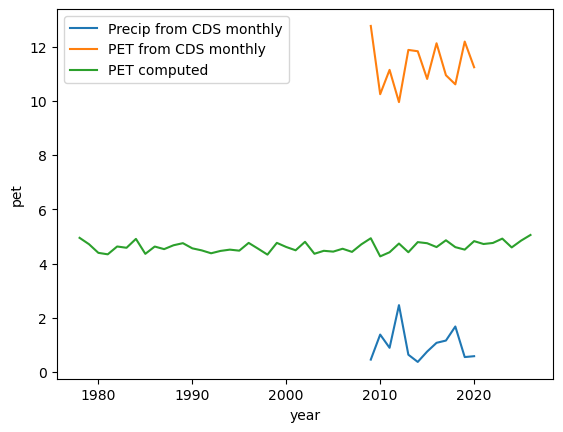

In [89]:
pr_ndj.assign_coords(valid_time = pr_ndj.valid_time.dt.year).plot()
pev_ndj.assign_coords(valid_time = pev_ndj.valid_time.dt.year).plot()
(df.to_xarray().pet).plot()
plt.legend(["Precip from CDS monthly", "PET from CDS monthly", "PET computed"])

### GMST

In [ ]:
! wget https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.dat -O ts/gmst-smoothed.dat

### ENSO

In [ ]:
ts = xr.open_dataset("data/nino34det-monthly_ersst.nc").nino34
ts_ndj = t s.sel(time = ts.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").mean()

df = ts_ndj.assign_coords(time = ts_ndj.time.dt.year).rename(time = "year").to_dataframe()

# csv for climate explorer
csv_fnm = "sam-fires_nino34det-ndj"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: November-January detrended ENSO index - Patagonia wildfires, c.barnes22@imperial.ac.uk"
str2 = "# nino34-ndj [degC] November-January values of Nino3.4 index, detrended by subtracting tropical SSTs at "+csv_fnm+".dat"
head = "# year nino34"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

### Southern Annular Mode

#### December mean SAM

In [ ]:
ts = xr.open_dataset("data/sam-monthly_cpc.nc").SAM
ts_dec = ts.groupby("TSAXIS.month")[12]

df = ts_dec.assign_coords(TSAXIS = ts_dec.TSAXIS.dt.year+1).rename(TSAXIS = "year").to_dataframe()

# csv for climate explorer
csv_fnm = "sam-fires_sam-dec"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: December southern annular mode - Patagonia wildfires, c.barnes22@imperial.ac.uk"
str2 = "# sam-dec [] December value of Southern Annular Mode index (obtained from https://stateoftheocean.osmc.noaa.gov/atm/data/sam.nc) at "+csv_fnm+".dat"
head = "# year sam"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## CORDEX

### hdwi

In [90]:
fl = sorted(glob.glob(fpath+"/models/cordex_hdwi/hdwi*.nc"))
ndays = {"chile2026" : 2, "patagonia" : 5}

for fnm in fl:

    print(fnm)
    mdl = "_".join(fnm.split("/")[-1].split("_")[1:])[:-3]
    
    ds = xr.open_dataset(fnm).hdwi / 1000
    ds = ds.sel(time = ds.time.dt.month.isin([12,1,2]))

    if "rlat" in ds.dims:
        xdim,ydim = ["rlon", "rlat"]
    elif "x" in ds.dims:
        xdim,ydim = ["x", "y"]
    else:
        print("Unknown xydims")
        continue
        
    nobs = ds.isel({xdim : 0, ydim : 0}).resample(time = "YE-JUL").count()

    for rnm in ["chile2026", "patagonia"]:
        print(rnm)
        nd = ndays[rnm]

        # csv for climate explorer
        csv_fnm = "sam-fires_hdwi_"+rnm+"_"+mdl
        csv_fullpath = "ts-cordex/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        if os.path.exists(csv_fnm): continue

        rnm_long = {"chile2026" : "Chile", "chile2024" : "Valparaiso", "patagonia" : "Patagonia"}[rnm]
        sf = eval("sf_"+rnm)
        rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)

        ts = ds.where(rm == 0, drop = True).mean([xdim,ydim])
        ts_nday = ts.rolling(time = nd).mean().resample(time = "YE-JUL").max()
        ts_nday = ts_nday.where(nobs >= 90, drop = True).reset_coords(drop = True)

        df = ts_nday.assign_coords(time = ts_nday.time.dt.year).rename(time = "year").to_dataframe()

        # create header lines for upload to Climate Explorer 
        str1 = "# contact ::  CORDEX "+mdl+" hdwi"+str(nd)+"x - Patagonia wildfires, c.barnes22@imperial.ac.uk"
        str2 = "# hdwi"+str(nd)+"x [] December-February maximum of "+str(nd)+"-day rolling mean of HDWI averaged ovver "+rnm_long+" at "+csv_fnm+".dat"
        head = "# year hdwi"+str(nd)+"x"

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    clear_output(wait = False)
print("Done.")

Done.


### pr

In [ ]:
fl = sorted(glob.glob(fpath+"/models/cordex_pr/pr-monthly*.nc"))

for fnm in fl:

    print(fnm)
    mdl = "_".join(fnm.split("/")[-1].split("_")[1:])[:-3]
    
    ds = xr.open_dataset(fnm).pr
    if ds.max() < 1: ds = ds * 86400

    if "rlat" in ds.dims:
        xdim,ydim = ["rlon", "rlat"]
    elif "x" in ds.dims:
        xdim,ydim = ["x", "y"]
    else:
        print("Unknown xydims")
        continue
        
    nmonths = ds.isel({xdim : 0, ydim : 0}).sel(time = ds.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").count()

    for rnm in ["chile2026", "patagonia"]:
        print(rnm)

        # csv for climate explorer
        csv_fnm = "sam-fires_pr-ndj_"+rnm+"_"+mdl
        csv_fullpath = "ts-cordex/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        if os.path.exists(csv_fnm): continue

        rnm_long = {"chile2026" : "Chile", "chile2024" : "Valparaiso", "patagonia" : "Patagonia"}[rnm]
        sf = eval("sf_"+rnm)
        rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)

        ts = ds.where(rm == 0, drop = True).mean([xdim,ydim])
        ts = ts.sel(time = ts.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").mean()
        ts = ts.where(nmonths == 3, drop = True).reset_coords(drop = True)
        df = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()

        
        
        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: CORDEX "+mdl+" NDJ precipitation - Patagonia wildfires, c.barnes22@imperial.ac.uk"
        str2 = "# pr-ndj [mm/3month] November-January daily mean rainfall rate averaged over "+rnm_long+" at "+csv_fnm+".dat"
        head = "# year pr-ndj"
    
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)
print("Done.")

Done.


### pet

Filenames need to be sorted out, but not right now

In [102]:
fl = sorted(glob.glob(fpath+"/models/cordex_pet/pet*.nc"))

for fnm in fl:

    print(fnm)
    mdl = "_".join(fnm.split("/")[-1].split("_")[1:])[:-3]
    
    ds = xr.open_dataset(fnm).pet
    if ds.max() < 1: ds = ds * 86400

    if "rlat" in ds.dims:
        xdim,ydim = ["rlon", "rlat"]
    elif "x" in ds.dims:
        xdim,ydim = ["x", "y"]
    else:
        print("Unknown xydims")
        continue
        
    nobs = ds.isel({xdim : 0, ydim : 0}).sel(time = ds.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").count()

    for rnm in ["chile2026", "patagonia"]:
        print(rnm)

        # csv for climate explorer
        csv_fnm = "sam-fires_pet-ndj_"+rnm+"_"+mdl
        csv_fullpath = "ts-cordex/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        if os.path.exists(csv_fnm): continue

        rnm_long = {"chile2026" : "Chile", "chile2024" : "Valparaiso", "patagonia" : "Patagonia"}[rnm]
        sf = eval("sf_"+rnm)
        rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)

        ts = ds.where(rm == 0, drop = True).mean([xdim,ydim])
        ts = ts.sel(time = ts.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").mean()
        ts = ts.where(nobs >= 90, drop = True).reset_coords(drop = True)
        df = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
        
        
        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: CORDEX "+mdl+" NDJ PET - Patagonia wildfires, c.barnes22@imperial.ac.uk"
        str2 = "# pet-ndj [mm/day] November-January daily mean potential evapotranspiration rate (Hargreaves method) averaged over "+rnm_long+" at "+csv_fnm+".dat"
        head = "# year pet-ndj"
    
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)
print("Done.")

Done.
